In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import sys
import pandas as pd
import os
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [3]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [5]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

In [6]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [7]:
def normalize_weights(w, var, gamma):
    return w * gamma / np.sqrt(var + 0.0001)

In [8]:
def normalize_bias(b, mean, var, beta, gamma):
    return (b - mean) * (gamma / np.sqrt(var + 0.0001)) + beta

In [9]:
def relu(z):
    return np.maximum(0, z)

## Predictions

### Unencrypted

In [10]:
weights = np.load('relu_weights.npy')
w1, b1, gamma, beta, mean, var, w2, b2 = weights

In [11]:
w_norm = normalize_weights(w1, var, gamma)
b_norm = normalize_bias(b1, mean, var, beta, gamma).reshape(1, -1)

In [12]:
layer1_clear = X_test.dot(w_norm) + b_norm
print(layer1_clear.max())
layer1_clear = relu(layer1_clear)
pred_clear = layer1_clear.dot(w2) + b2

15.213070747243


In [13]:
msse_clear = msse(pred_clear.flatten(), y_test)
print('MSSE relu clear: {}'.format(msse_clear))

MSSE relu clear: 50.82310580085749


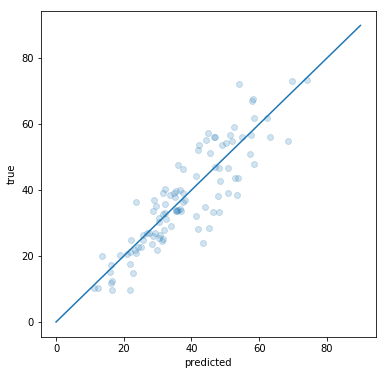

In [22]:
plot_predictions(pred_clear.flatten(), y_test, save_as='concrete_clear.pdf')

### Encrypted

In [15]:
X_test_enc = EA(X_test, to_encrypt=True)
w_norm_enc = EA(w_norm)
b_norm_enc = EA(b_norm)
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [16]:
layer1_enc = X_test_enc.dot(w_norm_enc) + b_norm_enc
layer1_enc.values()

array([[ 3.53480627e+00, -1.32728691e-01,  4.86260735e+00,
         1.55875673e+00,  3.14020030e+00,  5.68868895e+00,
         1.69788713e+00,  3.22473374e+00],
       [ 3.64372974e+00, -1.39780754e-01,  2.58826742e+00,
         1.85916610e+00,  2.08509652e+00,  2.61838153e+00,
         1.61294793e+00,  3.08799467e+00],
       [ 2.49279073e+00, -7.55775627e-01,  5.31872179e-01,
         5.46802795e+00, -6.27998950e-01,  8.02848973e-01,
         2.88139875e+00,  2.23522963e+00],
       [ 1.24568633e+00, -5.80694409e-01, -9.50918875e-02,
         3.89646446e+00, -2.83455617e+00,  3.82262113e+00,
         2.65876650e+00,  3.41359723e+00],
       [ 3.98362932e+00, -1.24261231e+00,  2.12161045e+00,
         8.81868276e+00,  4.82372162e-01, -1.12051778e+00,
         3.51974723e+00,  3.02181931e+00],
       [ 1.33718049e+00, -4.50391048e-01,  5.48090494e+00,
         2.24798476e+00, -2.94418917e-01,  7.26852919e+00,
         4.67098167e+00, -4.43872624e+00],
       [ 3.52980566e+00, -2.975314

In [17]:
layer1_enc.values().max()

15.213070747243

In [18]:
layer1_enc = layer1_enc.relu()
layer1_enc.values()

array([[ 3.86609505e+00,  1.69411659e+00,  4.82819662e+00,
         2.60561623e+00,  3.59506309e+00,  5.47170062e+00,
         2.68754642e+00,  3.65457950e+00],
       [ 3.94159239e+00,  1.69064302e+00,  3.23632004e+00,
         2.78375737e+00,  2.92094203e+00,  3.25562484e+00,
         2.63739054e+00,  3.56291037e+00],
       [ 3.17543514e+00,  1.39770134e+00,  2.03412526e+00,
         5.29651220e+00,  1.45676506e+00,  2.17901993e+00,
         3.42630404e+00,  3.01362200e+00],
       [ 2.42516695e+00,  1.47885699e+00,  1.71270091e+00,
         4.11914927e+00,  5.61111207e-01,  4.06692800e+00,
         3.28158948e+00,  3.78281176e+00],
       [ 4.18115488e+00,  1.18081307e+00,  2.94337122e+00,
         8.20120110e+00,  2.00746841e+00,  1.23399536e+00,
         3.85570586e+00,  3.51890138e+00],
       [ 2.47735304e+00,  1.54034181e+00,  5.30667015e+00,
         3.02155153e+00,  1.61515689e+00,  6.79375407e+00,
         4.68378559e+00,  7.26974024e-02],
       [ 3.86264388e+00,  1.613650

In [19]:
pred_enc = layer1_enc.dot(w2_enc) + b2_enc
pred_enc.values()

array([[25.26745229],
       [17.97632309],
       [25.72744504],
       [23.16432407],
       [33.5447941 ],
       [55.75151533],
       [24.49411331],
       [50.34661553],
       [31.35367582],
       [35.27323221],
       [56.27599461],
       [22.27488568],
       [28.86735321],
       [30.60700483],
       [18.32432197],
       [31.10682982],
       [60.94788338],
       [52.07319009],
       [49.25461387],
       [28.92559485],
       [23.84634811],
       [41.33072916],
       [23.29582453],
       [43.65741678],
       [50.88842713],
       [34.5076406 ],
       [31.98228267],
       [31.05197   ],
       [32.46147638],
       [19.71830998],
       [60.15801395],
       [45.54963561],
       [29.52839098],
       [30.61280023],
       [43.28856145],
       [33.50874011],
       [25.87776403],
       [28.22886053],
       [30.46528714],
       [23.76544386],
       [43.86460851],
       [23.48566668],
       [42.87219028],
       [31.76181965],
       [28.97112671],
       [32

In [20]:
msse_enc = msse(pred_enc.values().flatten(), y_test)
print('MSSE relu encrypted: {}'.format(msse_enc))

MSSE relu encrypted: 75.40003648605823


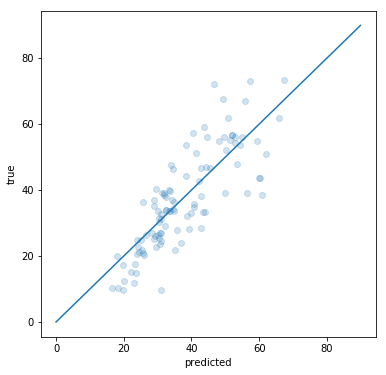

In [23]:
plot_predictions(pred_enc.values().flatten(), y_test, save_as='concrete_enc.pdf')